<a href="https://colab.research.google.com/github/KarynaSam/Python-DS/blob/main/HW_11.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Створюємо рекурентну нейронну мережу за допомогою механізмів Keras, яка буде класифікувати рецензії із датасету imdb



In [1]:
!pip install wandb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 19.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.6/190.6 kB 22.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 241.0/241.0 kB 26.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 7.0 MB/s eta 0:00:00
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8791 sha256=c38aa206bf5267cab66a3707e928852765859952595566c8ee2f47ae7cafb600
  Stored in directory: /root/.cache/pip/wheels/e7/f3/22/152153d6eb222ee7a56ff8617d80ee5207207a8c00a7aab794
Successfully built pathtools


In [2]:
import os
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Embedding, SimpleRNN, GRU, LSTM, Bidirectional
from keras.datasets import imdb
from keras.utils import pad_sequences
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.optimizers import Adam, SGD
from keras.metrics import Accuracy
from keras.models import load_model

from sklearn.metrics import confusion_matrix

import wandb
from wandb.keras import WandbMetricsLogger

Встановлення констант та налаштування

In [3]:
max_features = 10000  # кількість слів, що розглядаються як особливості
maxlen = 500  # обмеження кількості слів в тексті
batch_size = 128
n_epochs = 7
lr = 0.001

In [4]:
best_of_models = {}

In [5]:
wandb.init(project="HW_11_Simple_RNN", config={"lr": lr, "n_epochs": n_epochs, "batch_size": batch_size})

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [6]:
path = "/content/drive/MyDrive/Colab_Notebooks/HW_11_data"

In [7]:
def set_seed(seed_value):
    random.seed(seed_value)
    np.random.seed(seed_value)
    tf.random.set_seed(seed_value)
    os.environ["PYTHONHASHSEED"] = str(seed_value)
    os.environ["TF_DETERMINISTIC_OPS"] = "true"


set_seed(42)

In [8]:
(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=max_features)

17464789/17464789 [==============================] - 0s 0us/step


In [9]:
# Подивимося розміри наборів даних
train_data.shape, train_labels.shape, test_data.shape, test_labels.shape

((25000,), (25000,), (25000,), (25000,))

In [10]:
# Передпроцесинг послідовних даних:
# Застосування заздалегідь обраної максимальної довжини до послідовних даних тренувального та тестового наборів

input_train = pad_sequences(train_data, maxlen=maxlen)
input_test = pad_sequences(test_data, maxlen=maxlen)

In [11]:
# Ще раз подивимося на розміри ф'ючерів, що будуть подаватися до моделі
input_train.shape, input_test.shape

((25000, 500), (25000, 500))

Переклад отриманих даних на мову

In [12]:
word_index = imdb.get_word_index()

1641221/1641221 [==============================] - 0s 0us/step


Подивимося вхідні дані

In [13]:
print(train_data[0])

[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 5952, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32]


In [14]:
word_index = imdb.get_word_index()
reverse_word_index = {value: key for key, value in word_index.items()}

Тепер перекладемо їх

In [15]:
decoded_review = ' '.join([reverse_word_index.get(i - 3, '?') for i in train_data[0]])
decoded_review

"? this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert ? is an amazing actor and now the same being director ? father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for ? and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also ? to the two little boy's that played the ? of norman and paul they were just brilliant children are often left out of the ? list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for what they have done don't you th

**Побудова простої моделі RNN:**

In [16]:
model_Simple_RNN = Sequential()
# Створення порожньої моделі Sequential

# Додавання Embedding шару для перетворення слів в вектори фіксованої довжини
model_Simple_RNN.add(Embedding(max_features, 32))
# Параметри: кількість слів для розгляду як особливості та розмір вектора, що представляє кожне слово

# Додавання SimpleRNN шару з 32 вузлами
model_Simple_RNN.add(SimpleRNN(32))
# Параметр: кількість вузлів (розмір прихованого стану)

# Додавання Dense шару з одним вузлом та активацією sigmoid
model_Simple_RNN.add(Dense(1, activation='sigmoid'))
# Параметри: кількість вузлів (вихідний розмір) та функція активації (sigmoid для бінарної класифікації)

In [17]:
# Додамо колбек EarlyStopping, щоб зупинити навчання, якщо точність не покращується протягом певної кількості епох
early_stopping_callback = EarlyStopping(monitor='val_accuracy', patience=5, mode='max', verbose=1)

# Додамо колбек ModelCheckpoint, щоб зберегти найкращу модель за кожним епохом
model_checkpoint_callback = ModelCheckpoint(path+'/HW_11_best_model_RNN_Simple.h5', monitor='val_accuracy', mode='max', save_best_only=True, verbose=1)

In [18]:
callbacks=[early_stopping_callback, model_checkpoint_callback, WandbMetricsLogger()]

In [19]:
model_Simple_RNN.compile(optimizer=Adam(learning_rate=lr), loss='binary_crossentropy', metrics=['accuracy'])

In [20]:
model_Simple_RNN.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 32)          320000    
                                                                 
 simple_rnn (SimpleRNN)      (None, 32)                2080      
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 322113 (1.23 MB)
Trainable params: 322113 (1.23 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [21]:
history = model_Simple_RNN.fit(
    input_train, train_labels,
    epochs=n_epochs,
    batch_size=batch_size,
    validation_split=0.3,
    callbacks=callbacks)
# Запускаємо навчання моделі на тренувальних даних з розбиттям на тренувальну та валідаційну підмножини

Epoch 1/7
137/137 [==============================] - ETA: 0s - loss: 0.6914 - accuracy: 0.5433
Epoch 1: val_accuracy improved from -inf to 0.56347, saving model to /content/drive/MyDrive/Colab_Notebooks/HW_11_data/HW_11_best_model_RNN_Simple.h5
137/137 [==============================] - 25s 168ms/step - loss: 0.6914 - accuracy: 0.5433 - val_loss: 0.6754 - val_accuracy: 0.5635
Epoch 2/7
  1/137 [..............................] - ETA: 20s - loss: 0.6477 - accuracy: 0.6953

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


137/137 [==============================] - ETA: 0s - loss: 0.5739 - accuracy: 0.7364
Epoch 2: val_accuracy improved from 0.56347 to 0.73213, saving model to /content/drive/MyDrive/Colab_Notebooks/HW_11_data/HW_11_best_model_RNN_Simple.h5
137/137 [==============================] - 26s 193ms/step - loss: 0.5739 - accuracy: 0.7364 - val_loss: 0.5431 - val_accuracy: 0.7321
Epoch 3/7
137/137 [==============================] - ETA: 0s - loss: 0.3213 - accuracy: 0.8731
Epoch 3: val_accuracy improved from 0.73213 to 0.80360, saving model to /content/drive/MyDrive/Colab_Notebooks/HW_11_data/HW_11_best_model_RNN_Simple.h5
137/137 [==============================] - 25s 185ms/step - loss: 0.3213 - accuracy: 0.8731 - val_loss: 0.4493 - val_accuracy: 0.8036
Epoch 4/7
137/137 [==============================] - ETA: 0s - loss: 0.1603 - accuracy: 0.9446
Epoch 4: val_accuracy improved from 0.80360 to 0.82373, saving model to /content/drive/MyDrive/Colab_Notebooks/HW_11_data/HW_11_best_model_RNN_Simple.h

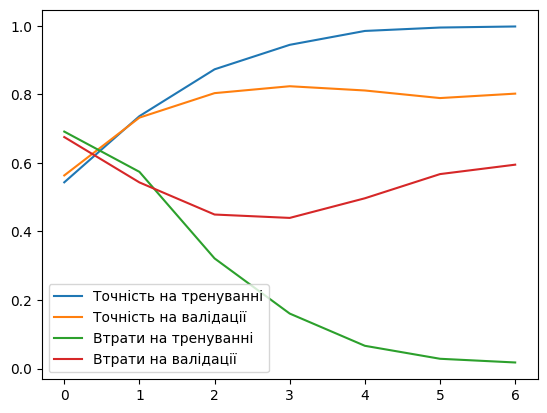

In [22]:
# Графіки для точності та втрат
plt.plot(history.history['accuracy'], label='Точність на тренуванні')
plt.plot(history.history['val_accuracy'], label='Точність на валідації')
plt.plot(history.history['loss'], label='Втрати на тренуванні')
plt.plot(history.history['val_loss'], label='Втрати на валідації')
plt.legend()
plt.show()

In [23]:
# Завантаження кращої збереженої моделі
best_model_SimpleRNN = load_model(path+'/HW_11_best_model_RNN_Simple.h5')

# Тестування на тестових даних
test_loss, test_accuracy = best_model_SimpleRNN.evaluate(input_test, test_labels)
best_of_models.update({"best_model_SimpleRNN": test_accuracy})

print(f"Втрати на тестовому наборі: {test_loss:.4f}")
print(f"Точність на тестовому наборі: {test_accuracy:.4f}")

782/782 [==============================] - 31s 38ms/step - loss: 0.4400 - accuracy: 0.8210
Втрати на тестовому наборі: 0.4400
Точність на тестовому наборі: 0.8210


In [24]:
# Прогнозування з використанням навченої моделі:

predictions = best_model_SimpleRNN.predict(input_test)

# Для отримання зрозумілішого вигляду прогнозів, їх можна перетворити в бінарний формат:
binary_predictions = [1 if pred > 0.5 else 0 for pred in predictions]

# Для порівняння можна вивести деякі прогнозовані значення поряд з фактичними значеннями
for i in range(10):
    print(f"Прогнозоване: {binary_predictions[i]}, Фактичне: {test_labels[i]}")

# Додатковий крок: Оцінка моделі
# Це дасть загальну точність моделі на тестових даних
# test_loss, test_acc = best_model_SimpleRNN.evaluate(input_test, test_labels)
# print('Test Loss: {}'.format(test_loss))
# print('Test Accuracy: {}'.format(test_acc))

782/782 [==============================] - 23s 29ms/step
Прогнозоване: 0, Фактичне: 0
Прогнозоване: 1, Фактичне: 1
Прогнозоване: 0, Фактичне: 1
Прогнозоване: 0, Фактичне: 0
Прогнозоване: 1, Фактичне: 1
Прогнозоване: 0, Фактичне: 1
Прогнозоване: 1, Фактичне: 1
Прогнозоване: 0, Фактичне: 0
Прогнозоване: 1, Фактичне: 0
Прогнозоване: 1, Фактичне: 1


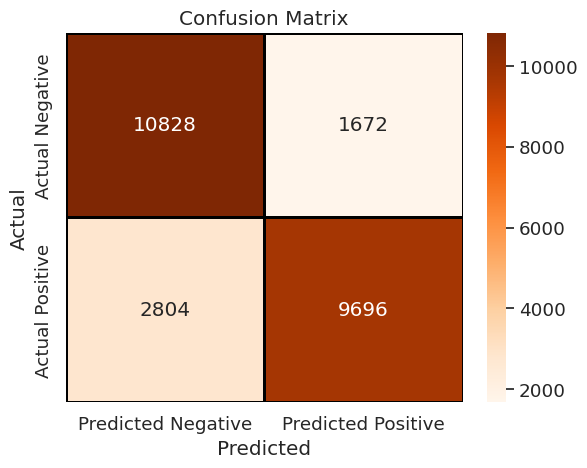

In [25]:
# Побудуємо confusion_matrix
confusion_mat = confusion_matrix(test_labels, binary_predictions)


# Використання Seaborn для візуалізації теплової карти
sns.set(font_scale=1.2)
sns.heatmap(confusion_mat, annot=True, fmt="d", cmap="Oranges", linewidths=1, linecolor="black",
            xticklabels=["Predicted Negative", "Predicted Positive"],
            yticklabels=["Actual Negative", "Actual Positive"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [26]:
wandb.finish()

epoch/accuracy,▁▄▆▇███
epoch/epoch,▁▂▃▅▆▇█
epoch/learning_rate,▁▁▁▁▁▁▁
epoch/loss,█▇▄▂▂▁▁
epoch/val_accuracy,▁▆▇██▇▇
epoch/val_loss,█▄▁▁▃▅▆
epoch/accuracy,0.99811
epoch/epoch,6
epoch/learning_rate,0.001
epoch/loss,0.01762
epoch/val_accuracy,0.80213


Висновок:
Точність - 80.1% на валідації, на тесті - 82.1%.
n_epoch=7;
lr=0,001;
batch_size=128
Trainable params: 322,113

**Побудова GRU моделі**

In [27]:
model_RNN_GRU = Sequential()
# Створення порожньої моделі Sequential

# Додавання Embedding шару для перетворення слів в вектори фіксованої довжини
model_RNN_GRU.add(Embedding(max_features, 32))
# Параметри: кількість слів для розгляду як особливості та розмір вектора, що представляє кожне слово

# Додавання GRU шару з 32 вузлами
model_RNN_GRU.add(GRU(32))
# Параметр: кількість вузлів (розмір прихованого стану)

# Додавання Dense шару з одним вузлом та активацією sigmoid
model_RNN_GRU.add(Dense(1, activation='sigmoid'))
# Параметри: кількість вузлів (вихідний розмір) та функція активації (sigmoid для бінарної класифікації)

In [28]:
# Замінимо колбек ModelCheckpoint, щоб зберегти найкращу модель за кожним епохом
model_checkpoint_callback = ModelCheckpoint(path+'/HW_11_best_model_RNN_GRU.h5', monitor='val_accuracy', mode='max', save_best_only=True, verbose=1)

# Додамо новий монітор
wandb.init(project="HW_11_RNN_GRU", config={"lr": lr, "n_epochs": n_epochs, "batch_size": batch_size})

wandb: Currently logged in as: ondatra410. Use `wandb login --relogin` to force relogin


In [29]:
callbacks=[early_stopping_callback, model_checkpoint_callback, WandbMetricsLogger()]

In [30]:
model_RNN_GRU.compile(optimizer=Adam(learning_rate=lr), loss='binary_crossentropy', metrics=['accuracy'])

In [31]:
model_RNN_GRU.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 32)          320000    
                                                                 
 gru (GRU)                   (None, 32)                6336      
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 326369 (1.24 MB)
Trainable params: 326369 (1.24 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [32]:
history_RNN_GRU = model_RNN_GRU.fit(
    input_train, train_labels,
    epochs=n_epochs,
    batch_size=batch_size,
    validation_split=0.3,
    callbacks=callbacks)
# Запускаємо навчання моделі на тренувальних даних з розбиттям на тренувальну та валідаційну підмножини

Epoch 1/7
137/137 [==============================] - ETA: 0s - loss: 0.5732 - accuracy: 0.6791
Epoch 1: val_accuracy improved from -inf to 0.83067, saving model to /content/drive/MyDrive/Colab_Notebooks/HW_11_data/HW_11_best_model_RNN_GRU.h5
137/137 [==============================] - 58s 402ms/step - loss: 0.5732 - accuracy: 0.6791 - val_loss: 0.3831 - val_accuracy: 0.8307
Epoch 2/7


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


137/137 [==============================] - ETA: 0s - loss: 0.2984 - accuracy: 0.8754
Epoch 2: val_accuracy improved from 0.83067 to 0.85947, saving model to /content/drive/MyDrive/Colab_Notebooks/HW_11_data/HW_11_best_model_RNN_GRU.h5
137/137 [==============================] - 58s 427ms/step - loss: 0.2984 - accuracy: 0.8754 - val_loss: 0.3331 - val_accuracy: 0.8595
Epoch 3/7
137/137 [==============================] - ETA: 0s - loss: 0.2093 - accuracy: 0.9210
Epoch 3: val_accuracy did not improve from 0.85947
137/137 [==============================] - 54s 394ms/step - loss: 0.2093 - accuracy: 0.9210 - val_loss: 0.3694 - val_accuracy: 0.8524
Epoch 4/7
137/137 [==============================] - ETA: 0s - loss: 0.1595 - accuracy: 0.9441
Epoch 4: val_accuracy improved from 0.85947 to 0.86067, saving model to /content/drive/MyDrive/Colab_Notebooks/HW_11_data/HW_11_best_model_RNN_GRU.h5
137/137 [==============================] - 51s 372ms/step - loss: 0.1595 - accuracy: 0.9441 - val_loss: 0.

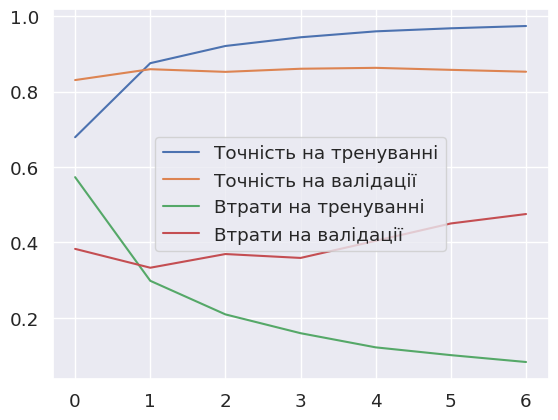

In [33]:
# Графіки для точності та втрат
plt.plot(history_RNN_GRU.history['accuracy'], label='Точність на тренуванні')
plt.plot(history_RNN_GRU.history['val_accuracy'], label='Точність на валідації')
plt.plot(history_RNN_GRU.history['loss'], label='Втрати на тренуванні')
plt.plot(history_RNN_GRU.history['val_loss'], label='Втрати на валідації')
plt.legend()
plt.show()

In [34]:
# Завантаження кращої збереженої моделі
best_model_RNN_GRU = load_model(path+'/HW_11_best_model_RNN_GRU.h5')

# Тестування на тестових даних
test_loss, test_accuracy = best_model_RNN_GRU.evaluate(input_test, test_labels)
best_of_models.update({"best_model_RNN_GRU": test_accuracy})

print(f"Втрати на тестовому наборі: {test_loss:.4f}")
print(f"Точність на тестовому наборі: {test_accuracy:.4f}")

782/782 [==============================] - 40s 48ms/step - loss: 0.4286 - accuracy: 0.8527
Втрати на тестовому наборі: 0.4286
Точність на тестовому наборі: 0.8527


In [35]:
# Прогнозування з використанням навченої моделі:

predictions = best_model_RNN_GRU.predict(input_test)

# Для отримання зрозумілішого вигляду прогнозів, їх можна перетворити в бінарний формат:
binary_predictions = [1 if pred > 0.5 else 0 for pred in predictions]

# Для порівняння можна вивести деякі прогнозовані значення поряд з фактичними значеннями
for i in range(10):
    print(f"Прогнозоване: {binary_predictions[i]}, Фактичне: {test_labels[i]}")

782/782 [==============================] - 37s 46ms/step
Прогнозоване: 0, Фактичне: 0
Прогнозоване: 1, Фактичне: 1
Прогнозоване: 1, Фактичне: 1
Прогнозоване: 1, Фактичне: 0
Прогнозоване: 1, Фактичне: 1
Прогнозоване: 1, Фактичне: 1
Прогнозоване: 1, Фактичне: 1
Прогнозоване: 0, Фактичне: 0
Прогнозоване: 1, Фактичне: 0
Прогнозоване: 1, Фактичне: 1


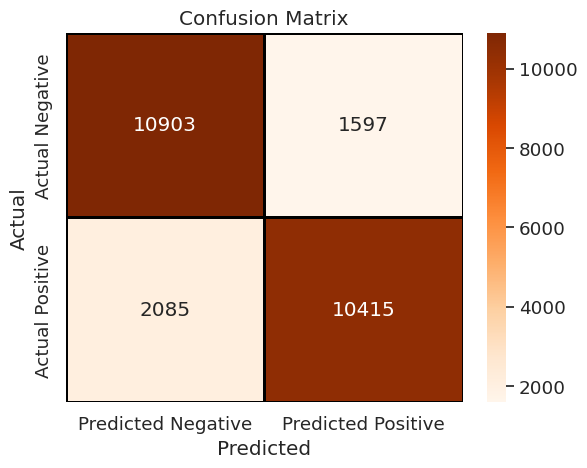

In [36]:
# Побудуємо confusion_matrix
confusion_mat = confusion_matrix(test_labels, binary_predictions)


# Використання Seaborn для візуалізації теплової карти
sns.set(font_scale=1.2)
sns.heatmap(confusion_mat, annot=True, fmt="d", cmap="Oranges", linewidths=1, linecolor="black",
            xticklabels=["Predicted Negative", "Predicted Positive"],
            yticklabels=["Actual Negative", "Actual Positive"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [37]:
wandb.finish()

epoch/accuracy,▁▆▇▇███
epoch/epoch,▁▂▃▅▆▇█
epoch/learning_rate,▁▁▁▁▁▁▁
epoch/loss,█▄▃▂▂▁▁
epoch/val_accuracy,▁▇▆▇█▇▆
epoch/val_loss,▃▁▃▂▅▇█
epoch/accuracy,0.974
epoch/epoch,6
epoch/learning_rate,0.001
epoch/loss,0.08308
epoch/val_accuracy,0.8528


Висновок:
Точність - 85.3% на валідації, на тесті - 85.2%.
n_epoch=7;
lr=0,001;
batch_size=128
Trainable params: 322,113

**Побудова моделі LSTM**

In [38]:
model_RNN_LSTM = Sequential()
# Створення порожньої моделі Sequential

# Додавання Embedding шару для перетворення слів в вектори фіксованої довжини
model_RNN_LSTM.add(Embedding(max_features, 32))
# Параметри: кількість слів для розгляду як особливості та розмір вектора, що представляє кожне слово

# Додавання LSTM шару з 32 вузлами
model_RNN_LSTM.add(LSTM(32))
# Параметр: кількість вузлів (розмір прихованого стану)

# Додавання Dense шару з одним вузлом та активацією sigmoid
model_RNN_LSTM.add(Dense(1, activation='sigmoid'))
# Параметри: кількість вузлів (вихідний розмір) та функція активації (sigmoid для бінарної класифікації)

In [39]:
# Замінимо колбек ModelCheckpoint, щоб зберегти найкращу модель за кожним епохом
model_checkpoint_callback = ModelCheckpoint(path+'/HW_11_best_model_RNN_LSTM.h5', monitor='val_accuracy', mode='max', save_best_only=True, verbose=1)

In [40]:
# Додамо новий монітор
wandb.init(project="HW_11_RNN_LSTM", config={"lr": lr, "n_epochs": n_epochs, "batch_size": batch_size})

In [41]:
callbacks=[early_stopping_callback, model_checkpoint_callback, WandbMetricsLogger()]

model_RNN_LSTM.compile(optimizer=Adam(learning_rate=lr), loss='binary_crossentropy', metrics=['accuracy'])

model_RNN_LSTM.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, None, 32)          320000    
                                                                 
 lstm (LSTM)                 (None, 32)                8320      
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 328353 (1.25 MB)
Trainable params: 328353 (1.25 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [42]:
history_RNN_LSTM = model_RNN_LSTM.fit(
    input_train, train_labels,
    epochs=n_epochs,
    batch_size=batch_size,
    validation_split=0.3,
    callbacks=callbacks)
# Запускаємо навчання моделі на тренувальних даних з розбиттям на тренувальну та валідаційну підмножини

Epoch 1/7
137/137 [==============================] - ETA: 0s - loss: 0.5109 - accuracy: 0.7427
Epoch 1: val_accuracy improved from -inf to 0.85813, saving model to /content/drive/MyDrive/Colab_Notebooks/HW_11_data/HW_11_best_model_RNN_LSTM.h5
137/137 [==============================] - 58s 395ms/step - loss: 0.5109 - accuracy: 0.7427 - val_loss: 0.3473 - val_accuracy: 0.8581
Epoch 2/7


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


137/137 [==============================] - ETA: 0s - loss: 0.2604 - accuracy: 0.9009
Epoch 2: val_accuracy improved from 0.85813 to 0.88280, saving model to /content/drive/MyDrive/Colab_Notebooks/HW_11_data/HW_11_best_model_RNN_LSTM.h5
137/137 [==============================] - 56s 411ms/step - loss: 0.2604 - accuracy: 0.9009 - val_loss: 0.2864 - val_accuracy: 0.8828
Epoch 3/7
137/137 [==============================] - ETA: 0s - loss: 0.1817 - accuracy: 0.9378
Epoch 3: val_accuracy improved from 0.88280 to 0.88533, saving model to /content/drive/MyDrive/Colab_Notebooks/HW_11_data/HW_11_best_model_RNN_LSTM.h5
137/137 [==============================] - 57s 416ms/step - loss: 0.1817 - accuracy: 0.9378 - val_loss: 0.3010 - val_accuracy: 0.8853
Epoch 4/7
137/137 [==============================] - ETA: 0s - loss: 0.1632 - accuracy: 0.9442
Epoch 4: val_accuracy did not improve from 0.88533
137/137 [==============================] - 58s 424ms/step - loss: 0.1632 - accuracy: 0.9442 - val_loss: 

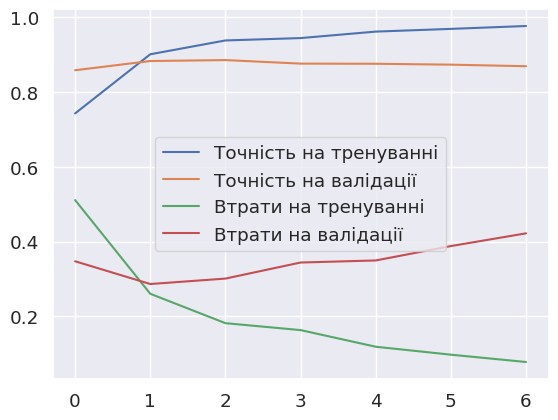

In [43]:
# Графіки для точності та втрат
plt.plot(history_RNN_LSTM.history['accuracy'], label='Точність на тренуванні')
plt.plot(history_RNN_LSTM.history['val_accuracy'], label='Точність на валідації')
plt.plot(history_RNN_LSTM.history['loss'], label='Втрати на тренуванні')
plt.plot(history_RNN_LSTM.history['val_loss'], label='Втрати на валідації')
plt.legend()
plt.show()

In [44]:
# Завантаження кращої збереженої моделі
best_model_RNN_LSTM = load_model(path+'/HW_11_best_model_RNN_LSTM.h5')

# Тестування на тестових даних
test_loss, test_accuracy = best_model_RNN_LSTM.evaluate(input_test, test_labels)
best_of_models.update({"best_model_RNN_LSTM": test_accuracy})

print(f"Втрати на тестовому наборі: {test_loss:.4f}")
print(f"Точність на тестовому наборі: {test_accuracy:.4f}")

782/782 [==============================] - 44s 54ms/step - loss: 0.3295 - accuracy: 0.8710
Втрати на тестовому наборі: 0.3295
Точність на тестовому наборі: 0.8710


In [45]:
# Прогнозування з використанням навченої моделі:

predictions = best_model_RNN_LSTM.predict(input_test)

# Для отримання зрозумілішого вигляду прогнозів, їх можна перетворити в бінарний формат:
binary_predictions = [1 if pred > 0.5 else 0 for pred in predictions]

# Для порівняння можна вивести деякі прогнозовані значення поряд з фактичними значеннями
for i in range(10):
    print(f"Прогнозоване: {binary_predictions[i]}, Фактичне: {test_labels[i]}")

782/782 [==============================] - 43s 52ms/step
Прогнозоване: 0, Фактичне: 0
Прогнозоване: 1, Фактичне: 1
Прогнозоване: 1, Фактичне: 1
Прогнозоване: 0, Фактичне: 0
Прогнозоване: 1, Фактичне: 1
Прогнозоване: 1, Фактичне: 1
Прогнозоване: 1, Фактичне: 1
Прогнозоване: 0, Фактичне: 0
Прогнозоване: 1, Фактичне: 0
Прогнозоване: 1, Фактичне: 1


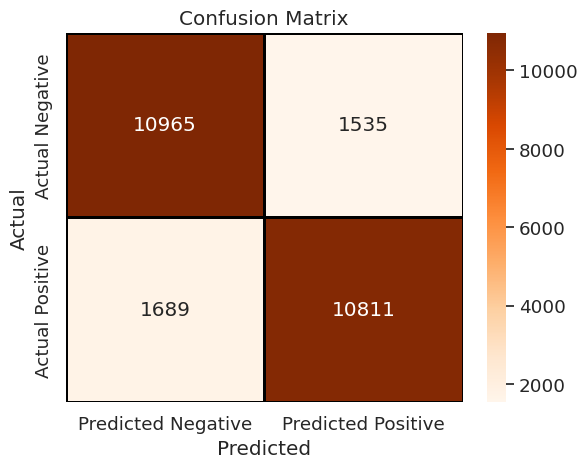

In [46]:
# Побудуємо confusion_matrix
confusion_mat = confusion_matrix(test_labels, binary_predictions)


# Використання Seaborn для візуалізації теплової карти
sns.set(font_scale=1.2)
sns.heatmap(confusion_mat, annot=True, fmt="d", cmap="Oranges", linewidths=1, linecolor="black",
            xticklabels=["Predicted Negative", "Predicted Positive"],
            yticklabels=["Actual Negative", "Actual Positive"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [47]:
wandb.finish()

epoch/accuracy,▁▆▇▇███
epoch/epoch,▁▂▃▅▆▇█
epoch/learning_rate,▁▁▁▁▁▁▁
epoch/loss,█▄▃▂▂▁▁
epoch/val_accuracy,▁▇█▆▅▅▄
epoch/val_loss,▄▁▂▄▄▆█
epoch/accuracy,0.97646
epoch/epoch,6
epoch/learning_rate,0.001
epoch/loss,0.07789
epoch/val_accuracy,0.86893


Висновок:
Точність - 86.89% на валідації, на тесті - 87.1%.
n_epoch=7;
lr=0,001;
batch_size=128
Trainable params: 322,113

**Побудова моделі BRNN LSTM:**

In [48]:
model_BRNN = Sequential()
# Створення порожньої моделі Sequential

# Додавання Embedding шару для перетворення слів в вектори фіксованої довжини
model_BRNN.add(Embedding(max_features, 32))
# Параметри: кількість слів для розгляду як особливості та розмір вектора, що представляє кожне слово

# Додавання Bidirectional LSTM шару з 32 вузлами
model_BRNN.add(Bidirectional(LSTM(32)))
# Параметр: кількість вузлів (розмір прихованого стану)

# Додавання Dense шару з одним вузлом та активацією sigmoid
model_BRNN.add(Dense(1, activation='sigmoid'))
# Параметри: кількість вузлів (вихідний розмір) та функція активації (sigmoid для бінарної класифікації)

# Замінимо колбек ModelCheckpoint, щоб зберегти найкращу модель за кожним епохом
model_checkpoint_callback = ModelCheckpoint(path+'/HW_11_best_model_BRNN.h5', monitor='val_accuracy', mode='max', save_best_only=True, verbose=1)

# Додамо новий монітор
wandb.init(project="HW_11_BRNN", config={"lr": lr, "n_epochs": n_epochs, "batch_size": batch_size})

In [49]:
callbacks=[early_stopping_callback, model_checkpoint_callback, WandbMetricsLogger()]

In [50]:
model_BRNN.compile(optimizer=Adam(learning_rate=lr), loss='binary_crossentropy', metrics=['accuracy'])

In [51]:
model_BRNN.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, None, 32)          320000    
                                                                 
 bidirectional (Bidirection  (None, 64)                16640     
 al)                                                             
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 336705 (1.28 MB)
Trainable params: 336705 (1.28 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [52]:
history_BRNN = model_BRNN.fit(
    input_train, train_labels,
    epochs=n_epochs,
    batch_size=batch_size,
    validation_split=0.3,
    callbacks=callbacks)
# Запускаємо навчання моделі на тренувальних даних з розбиттям на тренувальну та валідаційну підмножини

Epoch 1/7
137/137 [==============================] - ETA: 0s - loss: 0.5501 - accuracy: 0.7151
Epoch 1: val_accuracy improved from -inf to 0.84147, saving model to /content/drive/MyDrive/Colab_Notebooks/HW_11_data/HW_11_best_model_BRNN.h5
137/137 [==============================] - 108s 750ms/step - loss: 0.5501 - accuracy: 0.7151 - val_loss: 0.3741 - val_accuracy: 0.8415
Epoch 2/7


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


137/137 [==============================] - ETA: 0s - loss: 0.2928 - accuracy: 0.8842
Epoch 2: val_accuracy improved from 0.84147 to 0.87453, saving model to /content/drive/MyDrive/Colab_Notebooks/HW_11_data/HW_11_best_model_BRNN.h5
137/137 [==============================] - 99s 724ms/step - loss: 0.2928 - accuracy: 0.8842 - val_loss: 0.3024 - val_accuracy: 0.8745
Epoch 3/7
137/137 [==============================] - ETA: 0s - loss: 0.2119 - accuracy: 0.9243
Epoch 3: val_accuracy improved from 0.87453 to 0.87733, saving model to /content/drive/MyDrive/Colab_Notebooks/HW_11_data/HW_11_best_model_BRNN.h5
137/137 [==============================] - 104s 761ms/step - loss: 0.2119 - accuracy: 0.9243 - val_loss: 0.3005 - val_accuracy: 0.8773
Epoch 4/7
137/137 [==============================] - ETA: 0s - loss: 0.1872 - accuracy: 0.9350
Epoch 4: val_accuracy did not improve from 0.87733
137/137 [==============================] - 98s 713ms/step - loss: 0.1872 - accuracy: 0.9350 - val_loss: 0.3167 

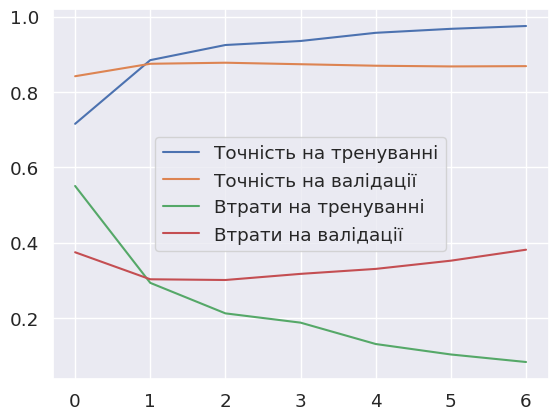

In [53]:
# Графіки для точності та втрат
plt.plot(history_BRNN.history['accuracy'], label='Точність на тренуванні')
plt.plot(history_BRNN.history['val_accuracy'], label='Точність на валідації')
plt.plot(history_BRNN.history['loss'], label='Втрати на тренуванні')
plt.plot(history_BRNN.history['val_loss'], label='Втрати на валідації')
plt.legend()
plt.show()

In [54]:
# Завантаження кращої збереженої моделі
best_model_BRNN = load_model(path+'/HW_11_best_model_BRNN.h5')

# Тестування на тестових даних
test_loss, test_accuracy = best_model_BRNN.evaluate(input_test, test_labels)
best_of_models.update({"best_model_BRNN": test_accuracy})

print(f"Втрати на тестовому наборі: {test_loss:.4f}")
print(f"Точність на тестовому наборі: {test_accuracy:.4f}")

782/782 [==============================] - 69s 86ms/step - loss: 0.3201 - accuracy: 0.8688
Втрати на тестовому наборі: 0.3201
Точність на тестовому наборі: 0.8688


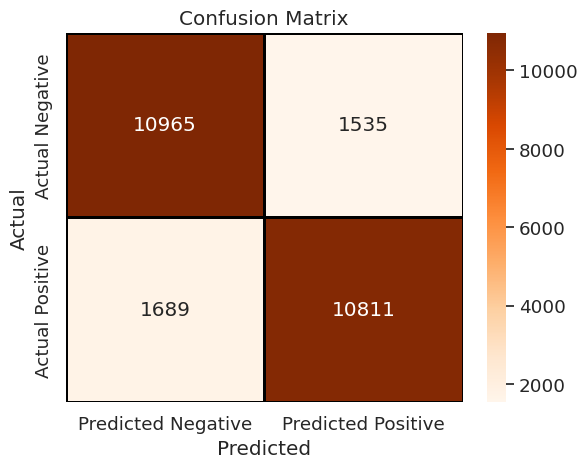

In [55]:
# Побудуємо confusion_matrix
confusion_mat = confusion_matrix(test_labels, binary_predictions)


# Використання Seaborn для візуалізації теплової карти
sns.set(font_scale=1.2)
sns.heatmap(confusion_mat, annot=True, fmt="d", cmap="Oranges", linewidths=1, linecolor="black",
            xticklabels=["Predicted Negative", "Predicted Positive"],
            yticklabels=["Actual Negative", "Actual Positive"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [56]:
wandb.finish()

epoch/accuracy,▁▆▇▇███
epoch/epoch,▁▂▃▅▆▇█
epoch/learning_rate,▁▁▁▁▁▁▁
epoch/loss,█▄▃▃▂▁▁
epoch/val_accuracy,▁▇█▇▆▆▆
epoch/val_loss,▇▁▁▂▄▅█
epoch/accuracy,0.9748
epoch/epoch,6
epoch/learning_rate,0.001
epoch/loss,0.08271
epoch/val_accuracy,0.86827


Висновок:
Точність - 86.8% на валідації, на тесті - 86.8%.
n_epoch=7;
lr=0,001;
batch_size=128
Trainable params: 322,113

**Deep BRNN**

In [57]:
model_Deep_BRNN = Sequential()
# Створення порожньої моделі Sequential

# Додавання Embedding шару для перетворення слів в вектори фіксованої довжини
model_Deep_BRNN.add(Embedding(max_features, 32))
# Параметри: кількість слів для розгляду як особливості та розмір вектора, що представляє кожне слово

# Додавання декількох Bidirectional LSTM шару з 32 вузлами
model_Deep_BRNN.add(Bidirectional(LSTM(32, return_sequences=True)))
model_Deep_BRNN.add(Bidirectional(LSTM(32)))
# Параметр: кількість вузлів (розмір прихованого стану) і return_sequences=True для першого шару, щоб надати послідовність як вхід на наступний шар

# Додавання Dense шару з одним вузлом та активацією sigmoid
model_Deep_BRNN.add(Dense(1, activation='sigmoid'))
# Параметри: кількість вузлів (вихідний розмір) та функція активації (sigmoid для бінарної класифікації)


# Замінимо колбек ModelCheckpoint, щоб зберегти найкращу модель за кожним епохом
model_checkpoint_callback = ModelCheckpoint(path+'/HW_11_best_model_Deep_BRNN.h5', monitor='val_accuracy', mode='max', save_best_only=True, verbose=1)


# Додамо новий монітор
wandb.init(project="HW_11_Deep_BRNN", config={"lr": lr, "n_epochs": n_epochs, "batch_size": batch_size})

In [58]:
callbacks=[early_stopping_callback, model_checkpoint_callback, WandbMetricsLogger()]
model_Deep_BRNN.compile(optimizer=Adam(learning_rate=lr), loss='binary_crossentropy', metrics=['accuracy'])
model_Deep_BRNN.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, None, 32)          320000    
                                                                 
 bidirectional_1 (Bidirecti  (None, None, 64)          16640     
 onal)                                                           
                                                                 
 bidirectional_2 (Bidirecti  (None, 64)                24832     
 onal)                                                           
                                                                 
 dense_4 (Dense)             (None, 1)                 65        
                                                                 
Total params: 361537 (1.38 MB)
Trainable params: 361537 (1.38 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [59]:
history_Deep_BRNN = model_Deep_BRNN.fit(
    input_train, train_labels,
    epochs=n_epochs,
    batch_size=batch_size,
    validation_split=0.3,
    callbacks=callbacks)
# Запускаємо навчання моделі на тренувальних даних з розбиттям на тренувальну та валідаційну підмножини

Epoch 1/7
137/137 [==============================] - ETA: 0s - loss: 0.5032 - accuracy: 0.7365
Epoch 1: val_accuracy improved from -inf to 0.85000, saving model to /content/drive/MyDrive/Colab_Notebooks/HW_11_data/HW_11_best_model_Deep_BRNN.h5
137/137 [==============================] - 228s 2s/step - loss: 0.5032 - accuracy: 0.7365 - val_loss: 0.3556 - val_accuracy: 0.8500
Epoch 2/7


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


137/137 [==============================] - ETA: 0s - loss: 0.2544 - accuracy: 0.9013
Epoch 2: val_accuracy improved from 0.85000 to 0.89013, saving model to /content/drive/MyDrive/Colab_Notebooks/HW_11_data/HW_11_best_model_Deep_BRNN.h5
137/137 [==============================] - 216s 2s/step - loss: 0.2544 - accuracy: 0.9013 - val_loss: 0.2843 - val_accuracy: 0.8901
Epoch 3/7
137/137 [==============================] - ETA: 0s - loss: 0.1857 - accuracy: 0.9335
Epoch 3: val_accuracy did not improve from 0.89013
137/137 [==============================] - 231s 2s/step - loss: 0.1857 - accuracy: 0.9335 - val_loss: 0.3073 - val_accuracy: 0.8800
Epoch 4/7
137/137 [==============================] - ETA: 0s - loss: 0.1223 - accuracy: 0.9593
Epoch 4: val_accuracy did not improve from 0.89013
137/137 [==============================] - 236s 2s/step - loss: 0.1223 - accuracy: 0.9593 - val_loss: 0.3473 - val_accuracy: 0.8744
Epoch 5/7
137/137 [==============================] - ETA: 0s - loss: 0.0891

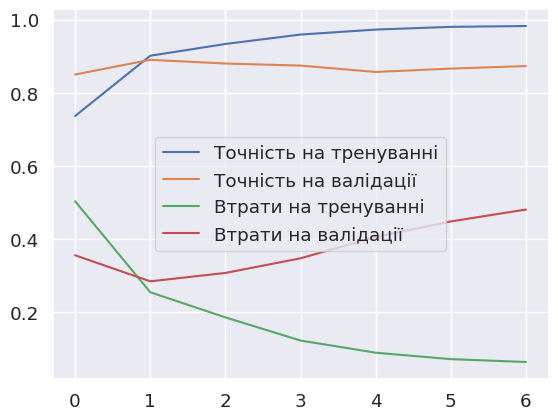

In [60]:
# Графіки для точності та втрат
plt.plot(history_Deep_BRNN.history['accuracy'], label='Точність на тренуванні')
plt.plot(history_Deep_BRNN.history['val_accuracy'], label='Точність на валідації')
plt.plot(history_Deep_BRNN.history['loss'], label='Втрати на тренуванні')
plt.plot(history_Deep_BRNN.history['val_loss'], label='Втрати на валідації')
plt.legend()
plt.show()

In [61]:
# Завантаження кращої збереженої моделі
best_model_Deep_BRNN = load_model(path+'/HW_11_best_model_Deep_BRNN.h5')

# Тестування на тестових даних
test_loss, test_accuracy = best_model_Deep_BRNN.evaluate(input_test, test_labels)
best_of_models.update({"best_model_Deep_BRNN": test_accuracy})

print(f"Втрати на тестовому наборі: {test_loss:.4f}")
print(f"Точність на тестовому наборі: {test_accuracy:.4f}")

782/782 [==============================] - 135s 170ms/step - loss: 0.3051 - accuracy: 0.8750
Втрати на тестовому наборі: 0.3051
Точність на тестовому наборі: 0.8750


In [62]:
# Прогнозування з використанням навченої моделі:

predictions = best_model_Deep_BRNN.predict(input_test)

# Для отримання зрозумілішого вигляду прогнозів, їх можна перетворити в бінарний формат:
binary_predictions = [1 if pred > 0.5 else 0 for pred in predictions]

# Для порівняння можна вивести деякі прогнозовані значення поряд з фактичними значеннями
for i in range(10):
    print(f"Прогнозоване: {binary_predictions[i]}, Фактичне: {test_labels[i]}")

782/782 [==============================] - 138s 170ms/step
Прогнозоване: 0, Фактичне: 0
Прогнозоване: 1, Фактичне: 1
Прогнозоване: 0, Фактичне: 1
Прогнозоване: 0, Фактичне: 0
Прогнозоване: 1, Фактичне: 1
Прогнозоване: 1, Фактичне: 1
Прогнозоване: 1, Фактичне: 1
Прогнозоване: 0, Фактичне: 0
Прогнозоване: 1, Фактичне: 0
Прогнозоване: 1, Фактичне: 1


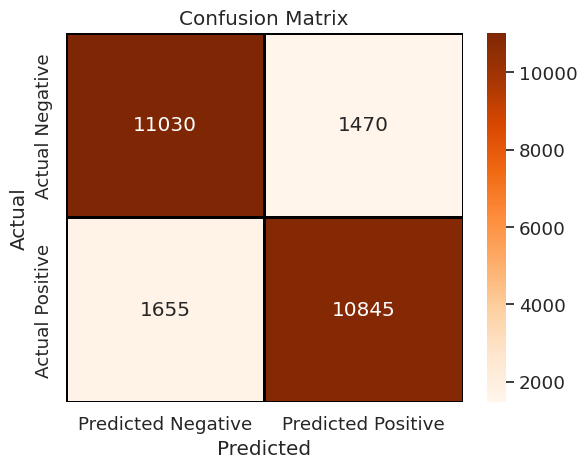

In [63]:
# Побудуємо confusion_matrix
confusion_mat = confusion_matrix(test_labels, binary_predictions)


# Використання Seaborn для візуалізації теплової карти
sns.set(font_scale=1.2)
sns.heatmap(confusion_mat, annot=True, fmt="d", cmap="Oranges", linewidths=1, linecolor="black",
            xticklabels=["Predicted Negative", "Predicted Positive"],
            yticklabels=["Actual Negative", "Actual Positive"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [64]:
wandb.finish()

epoch/accuracy,▁▆▇▇███
epoch/epoch,▁▂▃▅▆▇█
epoch/learning_rate,▁▁▁▁▁▁▁
epoch/loss,█▄▃▂▁▁▁
epoch/val_accuracy,▁█▆▅▂▄▅
epoch/val_loss,▄▁▂▃▅▇█
epoch/accuracy,0.98263
epoch/epoch,6
epoch/learning_rate,0.001
epoch/loss,0.06366
epoch/val_accuracy,0.87307


Висновок:
Точність - 87.3% на валідації, на тесті - 87.5%.
n_epoch=7;
lr=0,001;
batch_size=128
Trainable params: 322,113

In [65]:
print("Результати тестів всіх побудованих моделей")
for item in best_of_models.items():
  print(item)

Результати тестів всіх побудованих моделей
('best_model_SimpleRNN', 0.8209599852561951)
('best_model_RNN_GRU', 0.8527200222015381)
('best_model_RNN_LSTM', 0.8710399866104126)
('best_model_BRNN', 0.8688399791717529)
('best_model_Deep_BRNN', 0.875)
